## RAVDESS Dataset

### "The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

This portion of the RAVDESS contains 1440 files: 60 trials per actor x 24 actors = 1440. The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

1. Audio-only (03)
2. Speech (01)
3. Fearful (06)
4. Normal intensity (01)
5. Statement "dogs" (02)
6. 1st Repetition (01)
7. 12th Actor (12)
Female, as the actor ID number is even.

In [1]:
# load dataset from archive folder (Actor_01, Actor_02...), .wav file
import os
import pandas as pd

def load_dataset(archive_path):
    data = []
    for actor_folder in os.listdir(archive_path):
        actor_path = os.path.join(archive_path, actor_folder)
        if os.path.isdir(actor_path):
            for file_name in os.listdir(actor_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(actor_path, file_name)
                    # Extract data from file name
                    parts = file_name.split('-')
                    emotion_code = parts[2]
                    emotion_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
                    emotion = emotion_map.get(emotion_code, 'unknown')
                    data.append({'file_path': file_path, 'emotion': emotion})
    df = pd.DataFrame(data)
    return df

In [2]:
# See dataset
df = load_dataset('archive')
print(df.head())
len(df)

                                   file_path  emotion
0  archive/Actor_11/03-01-02-02-02-01-11.wav     calm
1  archive/Actor_11/03-01-07-01-02-02-11.wav  disgust
2  archive/Actor_11/03-01-03-01-01-01-11.wav    happy
3  archive/Actor_11/03-01-06-01-01-01-11.wav  fearful
4  archive/Actor_11/03-01-03-02-02-02-11.wav    happy


1440

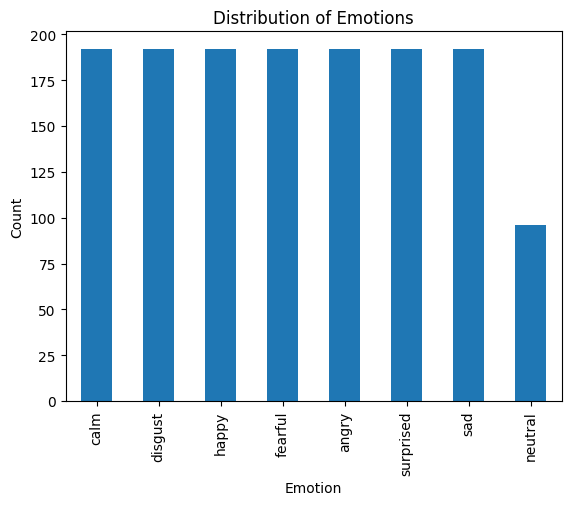

In [3]:
# Distribution of emotions graph
import matplotlib.pyplot as plt
emotion_counts = df['emotion'].value_counts()
emotion_counts.plot(kind='bar')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotions')
plt.show()

In [4]:
# Combine neutral and calm into neutral
df['emotion'] = df['emotion'].replace({'calm': 'neutral'})
print(df['emotion'].value_counts())

emotion
neutral      288
disgust      192
happy        192
fearful      192
angry        192
surprised    192
sad          192
Name: count, dtype: int64


In [5]:
import numpy as np
import librosa

SR = 16000  # Sample rate
DURATION = 3.0  # Duration in seconds
#Start
START = 1.0  # Start time in seconds
START_SAMPLE = int(SR * START)  # Start sample index
SAMPLES = int(SR * DURATION)  # Total samples per audio file

In [6]:
# Get 1-4 seconds from audio file, pad with zeros if less than 4 seconds

def load_audio(path, sr=SR, samples=SAMPLES, start_sample=START_SAMPLE):
    y, _ = librosa.load(path, sr=sr, mono=True)
    # Trim from start_sample, then pad if needed
    y = y[start_sample:] if len(y) > start_sample else np.array([])
    if len(y) >= samples:
        y = y[:samples]
    else:
        y = np.pad(y, (0, samples - len(y)), "constant")
    return y

In [7]:
import numpy as np

N_MELS = 64
N_FFT = 1024
# HOP_LENGTH = 160
HOP_LENGTH = 256
# With SR=16000, DURATION=2.5s, calculate target frames
TARGET_FRAMES = int(np.ceil((SAMPLES - N_FFT) / HOP_LENGTH)) + 1

def waveform_to_logmel(y, sr=SR):
    """Convert a waveform array to log-mel spectrogram."""
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH, fmin=20, fmax=8000, power=2.0, window='hann', center=True)
    # logmel = librosa.power_to_db(mel, ref=np.max)
    logmel = np.log(mel + 1e-6)  # Use log to avoid negative infinity

    # Enforce fixed time frames
    frames = logmel.shape[1]
    if frames < TARGET_FRAMES:
        logmel = np.pad(logmel, ((0, 0), (0, TARGET_FRAMES - frames)), mode='constant')
    elif frames > TARGET_FRAMES:
        logmel = logmel[:, :TARGET_FRAMES]

    # per-sample normalization
    logmel = (logmel - logmel.mean()) / (logmel.std() + 1e-6)

    return logmel.astype(np.float32)


# Will optimize it better
def wav_to_logmel(path, sr=SR):
    """Load audio from path and convert to log-mel spectrogram."""
    y = load_audio(path, sr=sr)
    return waveform_to_logmel(y, sr=sr)

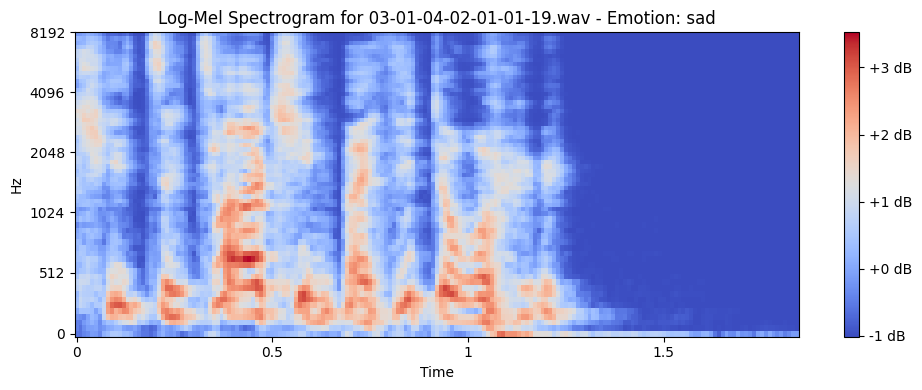

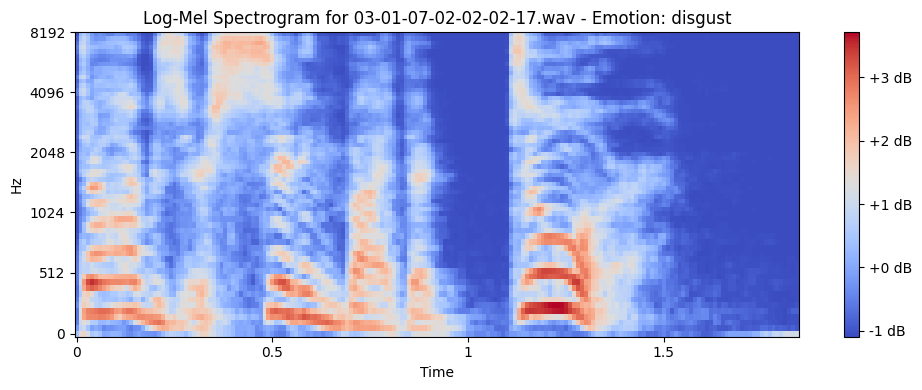

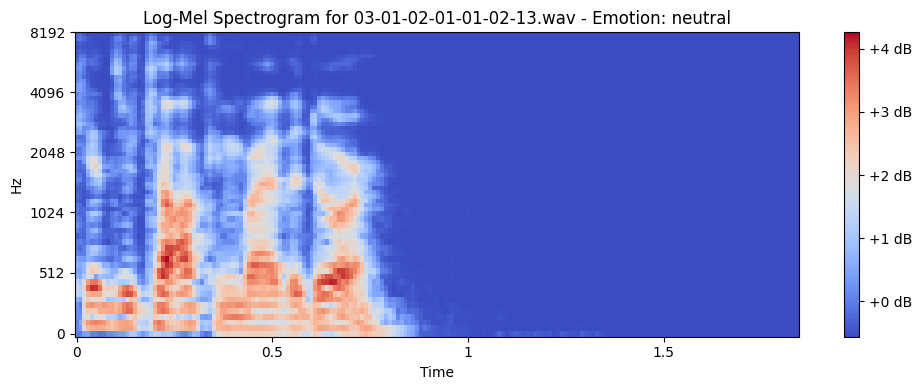

In [8]:
# Show three random log-mel spectrograms
import random
sample_files = random.sample(list(df['file_path']), 3)
for file in sample_files:
    logmel = wav_to_logmel(file)
    label = df[df['file_path'] == file]['emotion'].values[0]
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(logmel, sr=SR, hop_length=160, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Log-Mel Spectrogram for {os.path.basename(file)} - Emotion: {label}')
    plt.tight_layout()
    plt.show()

In [9]:
import numpy as np
import librosa
import random

def augment_waveform_offline(y, sr):
    # Random gain
    if random.random() < 0.5:
        y = y * np.random.uniform(0.8, 1.2)

    # Add low-level noise
    if random.random() < 0.3:
        y = y + 0.005 * np.random.randn(len(y))

    # Pitch shift (±1 semitone)
    if random.random() < 0.3:
        y = librosa.effects.pitch_shift(
            y, sr=sr, n_steps=np.random.uniform(-1, 1)
        )

    # Speed perturbation
    if random.random() < 0.3:
        y = librosa.effects.time_stretch(
            y, rate=np.random.uniform(0.9, 1.1)
        )

    return y


In [10]:
def parse_actor_id(file_path):
    base_name = os.path.basename(file_path)
    actor_id = int(base_name.split('-')[-1].split('.')[0])
    return actor_id

df = df[df['emotion'] != 'unknown'].copy()  # Filter out unknown emotions
df['actor_id'] = df['file_path'].apply(parse_actor_id)

df [["emotion", "actor_id"]].head(), df["emotion"].value_counts()

(   emotion  actor_id
 0  neutral        11
 1  disgust        11
 2    happy        11
 3  fearful        11
 4    happy        11,
 emotion
 neutral      288
 disgust      192
 happy        192
 fearful      192
 angry        192
 surprised    192
 sad          192
 Name: count, dtype: int64)

In [11]:
# Split dataset into train, validation, and test based on actor IDs

rng = np.random.default_rng(42)
all_actors = df['actor_id'].unique()
rng.shuffle(all_actors)

# Better split: 4 actors for test, 4 for val, 16 for train
test_actors = set(all_actors[:4])
val_actors = set(all_actors[4:8])
train_actors = set(all_actors[8:])

train_df = df[df['actor_id'].isin(train_actors)].copy()
test_df = df[df['actor_id'].isin(test_actors)].copy()
val_df = df[df['actor_id'].isin(val_actors)].copy()
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 960, Val: 240, Test: 240


In [12]:
# Save processed log-mel spectrograms to .npy files
import os
import numpy as np

def preprocess_and_save(df, out_dir='logmel_data', n_augment=2):
    os.makedirs(out_dir, exist_ok=True)
    new_rows = []

    for _, row in df.iterrows():
        wav_path = row['file_path']

        # Load waveform
        y, sr = librosa.load(wav_path, sr=SR)

        base_name = os.path.basename(wav_path).replace('.wav', '')

        # Original spectrogram
        logmel = wav_to_logmel(wav_path)
        out_path = os.path.join(out_dir, f'{base_name}_orig.npy')
        np.save(out_path, logmel)

        new_row = row.copy()
        new_row['spectrogram_path'] = out_path
        new_rows.append(new_row)

        # Augmented spectrograms
        for i in range(n_augment):
            y_aug = augment_waveform_offline(y, sr)
            logmel_aug = waveform_to_logmel(y_aug, sr=sr)

            out_path_aug = os.path.join(out_dir, f'{base_name}_aug{i+1}.npy')
            np.save(out_path_aug, logmel_aug)

            new_row_aug = row.copy()
            new_row_aug['spectrogram_path'] = out_path_aug
            new_rows.append(new_row_aug)

    return pd.DataFrame(new_rows)

In [13]:
# Update train and validation dataframes with spectrogram paths
# train_df = preprocess_and_save(train_df, out_dir='logmel_data/train', n_augment=2)
train_df = preprocess_and_save(train_df, out_dir='logmel_data/train', n_augment=4)
val_df = preprocess_and_save(val_df, out_dir='logmel_data/val', n_augment=0)
test_df = preprocess_and_save(test_df, out_dir='logmel_data/test', n_augment=0)

In [14]:
# Check updated dataframes and shapes
print(train_df.head())
print(val_df.head())
print(test_df.head())
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

                                   file_path  emotion  actor_id  \
0  archive/Actor_11/03-01-02-02-02-01-11.wav  neutral        11   
0  archive/Actor_11/03-01-02-02-02-01-11.wav  neutral        11   
0  archive/Actor_11/03-01-02-02-02-01-11.wav  neutral        11   
0  archive/Actor_11/03-01-02-02-02-01-11.wav  neutral        11   
0  archive/Actor_11/03-01-02-02-02-01-11.wav  neutral        11   

                                  spectrogram_path  
0  logmel_data/train/03-01-02-02-02-01-11_orig.npy  
0  logmel_data/train/03-01-02-02-02-01-11_aug1.npy  
0  logmel_data/train/03-01-02-02-02-01-11_aug2.npy  
0  logmel_data/train/03-01-02-02-02-01-11_aug3.npy  
0  logmel_data/train/03-01-02-02-02-01-11_aug4.npy  
                                     file_path    emotion  actor_id  \
420  archive/Actor_05/03-01-07-01-01-02-05.wav    disgust         5   
421  archive/Actor_05/03-01-06-02-02-02-05.wav    fearful         5   
422  archive/Actor_05/03-01-03-01-01-02-05.wav      happy         

In [15]:
# Calling it above

# import os

# def parse_actor_id(file_path):
#     base_name = os.path.basename(file_path)
#     actor_id = int(base_name.split('-')[-1].split('.')[0])
#     return actor_id

# df = df[df['emotion'] != 'unknown'].copy()  # Filter out unknown emotions
# df['actor_id'] = df['file_path'].apply(parse_actor_id)

# df [["emotion", "actor_id"]].head(), df["emotion"].value_counts()

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# EMOTIONS = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
# Combined neutral and calm
EMOTIONS = ["neutral", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

class AttentionBlock(nn.Module):
    """Channel attention mechanism"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SpectrogramCNNV2(nn.Module):
    """Improved CNN with attention and residual connections"""
    def __init__(self, num_classes=len(EMOTIONS), dropout=0.5):
        super().__init__()
        
        # # Initial conv block
        # self.conv1 = nn.Sequential(
        #     nn.Conv2d(1, 32, 3, padding=1),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.Conv2d(32, 32, 3, padding=1),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2),
        #     nn.Dropout2d(0.1),
        # )
        
        # # Second block with attention
        # self.conv2 = nn.Sequential(
        #     nn.Conv2d(32, 64, 3, padding=1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, 3, padding=1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        # )
        # self.attention2 = AttentionBlock(64)
        # self.pool2 = nn.Sequential(nn.MaxPool2d(2), nn.Dropout2d(0.2))
        
        # # Third block with attention
        # self.conv3 = nn.Sequential(
        #     nn.Conv2d(64, 128, 3, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.Conv2d(128, 128, 3, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        # )
        # self.attention3 = AttentionBlock(128)
        # self.pool3 = nn.Sequential(nn.MaxPool2d(2), nn.Dropout2d(0.3))
        
        # # Fourth block 
        # self.conv4 = nn.Sequential(
        #     nn.Conv2d(128, 256, 3, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.Conv2d(256, 256, 3, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        # )
        # self.attention4 = AttentionBlock(256)
        # self.pool4 = nn.Sequential(nn.AdaptiveAvgPool2d((2, 2)), nn.Dropout2d(0.4))
        
        # # Classifier
        # self.classifier = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(256 * 2 * 2, 256),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
        #     nn.Linear(256, 128),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
        #     nn.Linear(128, num_classes)
        # )

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),  # Added back second conv
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),  # Added back second conv
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.attention = AttentionBlock(128)
        self.pool3 = nn.Sequential(
            nn.AdaptiveAvgPool2d((2, 2)),
            nn.Dropout2d(0.3)
        )

        # Classifier - moderate size
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 2 * 2, 128),  # 512 -> 128
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.attention(x)
        x = self.pool3(x)
        x = self.classifier(x)
        return x
    # def forward(self, x):
    #     x = self.conv1(x)
        
    #     x = self.conv2(x)
    #     x = self.attention2(x)
    #     x = self.pool2(x)
        
    #     x = self.conv3(x)
    #     x = self.attention3(x)
    #     x = self.pool3(x)
        
    #     x = self.conv4(x)
    #     x = self.attention4(x)
    #     x = self.pool4(x)
        
    #     x = self.classifier(x)
    #     return x

In [17]:
# quick shape check (uses your N_MELS and TARGET_FRAMES vars if defined)
model = SpectrogramCNNV2(num_classes=len(EMOTIONS))
dummy = torch.randn(4, 1, N_MELS, TARGET_FRAMES)
logits = model(dummy)
logits.shape

torch.Size([4, 7])

In [18]:
from torch.utils.data import Dataset, DataLoader

emotion_to_idx = {emotion: idx for idx, emotion in enumerate(EMOTIONS)}
idx_to_emotion = {idx: emotion for emotion, idx in emotion_to_idx.items()}

df = df[df['emotion'].isin(EMOTIONS)].copy()  # Ensure only known emotions are included

In [19]:
import torchaudio.transforms as T

class RavdessSpectrogramDataset(Dataset):
    def __init__(self, df, emotion_to_idx, sr=SR, augment=False):
        self.df = df.reset_index(drop=True)
        self.emotion_to_idx = emotion_to_idx
        self.sr = sr
        self.augment = augment
        self.time_mask = T.TimeMasking(time_mask_param=40)
        self.freq_mask = T.FrequencyMasking(freq_mask_param=15)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # row = self.df.iloc[idx]
        # file_path = row['file_path']
        # logmel = wav_to_logmel(file_path, sr=self.sr)
        # logmel = torch.tensor(logmel, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        # if self.augment:
        #     logmel = self.time_mask(logmel)
        #     logmel = self.freq_mask(logmel)

        # label = self.emotion_to_idx[row['emotion']]
        # return logmel, torch.tensor(label, dtype=torch.long)

        row = self.df.iloc[idx]

        logmel = np.load(row['spectrogram_path'])
        logmel = torch.tensor(logmel, dtype=torch.float32).unsqueeze(0)

        if self.augment:
            logmel = self.time_mask(logmel)
            logmel = self.freq_mask(logmel)
        
        label = self.emotion_to_idx[row['emotion']]
        return logmel, torch.tensor(label, dtype=torch.long)

In [20]:
# Split dataset into train and test based on actor IDs

# NOTE: Commented because we will do splitting before

# rng = np.random.default_rng(42)
# all_actors = df['actor_id'].unique()
# rng.shuffle(all_actors)

# test_actors = set(all_actors[:4])
# val_actors = set(all_actors[4:6])
# train_actors = set(all_actors[6:])

# train_df = df[df['actor_id'].isin(train_actors)].copy()
# test_df = df[df['actor_id'].isin(test_actors)].copy()
# val_df = df[df['actor_id'].isin(val_actors)].copy()
# len(train_df), len(test_df), len(val_df)

In [21]:
# Create datasets and dataloaders

BATCH_SIZE = 32

train_ds = RavdessSpectrogramDataset(train_df, emotion_to_idx, augment=True)
val_ds = RavdessSpectrogramDataset(val_df, emotion_to_idx, augment=False)
test_ds = RavdessSpectrogramDataset(test_df, emotion_to_idx, augment=False)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = SpectrogramCNNV2(num_classes=len(EMOTIONS), dropout=0.4).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Use class weights to handle imbalance (neutral has fewer samples)
from collections import Counter
emotion_counts = Counter(train_df['emotion'])
total = sum(emotion_counts.values())
class_weights = torch.tensor([total / (len(EMOTIONS) * emotion_counts[e]) for e in EMOTIONS], dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

def run_one_epoch_train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, correct / total


def evaluate(model, loader, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        correct = 0
        total = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += x.size(0)

    return total_loss / total, correct / total

def get_predictiion(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())
    return all_preds, all_labels

Device: cpu
Total parameters: 355,943
Class weights: tensor([0.7143, 1.0714, 1.0714, 1.0714, 1.0714, 1.0714, 1.0714])


In [23]:
# Run train with cosine annealing and early stopping
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Cosine annealing with warm restarts works better for this task
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

best_val_acc = 0.0
best_train_acc = 0.0
best_model_state = None
patience_counter = 0
PATIENCE = 15  # More patience with cosine annealing

EPOCHS = 100

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = run_one_epoch_train(model, train_dl, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_dl, criterion, device)
    scheduler.step()
    
    current_lr = optimizer.param_groups[0]['lr']

    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_train_acc = train_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        marker = " *"
    else:
        patience_counter += 1
        marker = ""
        if patience_counter >= PATIENCE:
            print("Early stopping triggered")
            break
    
    print(f'Epoch {epoch}/{EPOCHS} - LR: {current_lr:.2e} - '
          f'Train Loss: {train_loss:.4f}, Train Acc: {(train_acc*100):.2f}% - '
          f'Val Loss: {val_loss:.4f}, Val Acc: {(val_acc*100):.2f}%{marker}')

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nLoaded best model with Val Acc: {best_val_acc*100:.2f}% and Train Acc: {best_train_acc*100:.2f}%")

Epoch 1/100 - LR: 9.76e-04 - Train Loss: 1.8515, Train Acc: 24.98% - Val Loss: 1.7201, Val Acc: 34.17% *
Epoch 2/100 - LR: 9.05e-04 - Train Loss: 1.7533, Train Acc: 34.23% - Val Loss: 1.6924, Val Acc: 35.83% *
Epoch 3/100 - LR: 7.94e-04 - Train Loss: 1.7115, Train Acc: 36.46% - Val Loss: 1.6542, Val Acc: 44.17% *
Epoch 4/100 - LR: 6.55e-04 - Train Loss: 1.6969, Train Acc: 37.35% - Val Loss: 1.6184, Val Acc: 43.75%
Epoch 5/100 - LR: 5.01e-04 - Train Loss: 1.6542, Train Acc: 40.25% - Val Loss: 1.6664, Val Acc: 40.83%
Epoch 6/100 - LR: 3.46e-04 - Train Loss: 1.6256, Train Acc: 41.23% - Val Loss: 1.5795, Val Acc: 45.00% *
Epoch 7/100 - LR: 2.07e-04 - Train Loss: 1.6031, Train Acc: 42.71% - Val Loss: 1.5970, Val Acc: 43.33%
Epoch 8/100 - LR: 9.64e-05 - Train Loss: 1.5881, Train Acc: 44.02% - Val Loss: 1.5517, Val Acc: 47.08% *
Epoch 9/100 - LR: 2.54e-05 - Train Loss: 1.5708, Train Acc: 44.79% - Val Loss: 1.5685, Val Acc: 44.17%
Epoch 10/100 - LR: 1.00e-03 - Train Loss: 1.5643, Train Acc: 45

              precision    recall  f1-score   support

     neutral       0.58      0.79      0.67        48
       happy       0.76      0.50      0.60        32
         sad       0.36      0.44      0.39        32
       angry       0.72      0.88      0.79        32
     fearful       0.78      0.56      0.65        32
     disgust       0.63      0.59      0.61        32
   surprised       1.00      0.69      0.81        32

    accuracy                           0.65       240
   macro avg       0.69      0.64      0.65       240
weighted avg       0.68      0.65      0.65       240



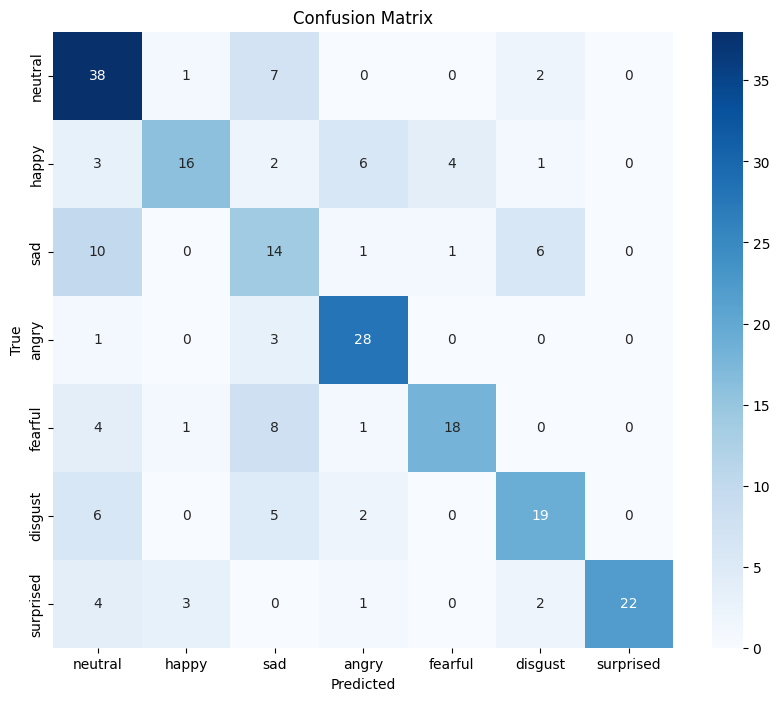

In [24]:
preds, labels = get_predictiion(model, test_dl, device)
print(classification_report(labels, preds, target_names=EMOTIONS))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=EMOTIONS, yticklabels=EMOTIONS, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()